##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deep Convolutional Generative Adversarial Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](./images/gan1.png)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](./images/gan2.png)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, we recommend MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Import TensorFlow and other libraries

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.1.0'

In [4]:
# To generate GIFs
!pip install -q imageio

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from numpy import zeros
from numpy import ones
import csv

from IPython import display

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [7]:
train_path = '../datasets/calf'

input_shape = (1, 128, 128, 1)
batch_size = 64

train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator()

train_images = train_data_gen.flow_from_directory(train_path, 
        color_mode='grayscale',shuffle=True, target_size=input_shape[1:3], 
        batch_size=batch_size, class_mode=None)

Found 507 images belonging to 2 classes.


In [8]:
64*6+59+64

507

(64, 128, 128, 1)


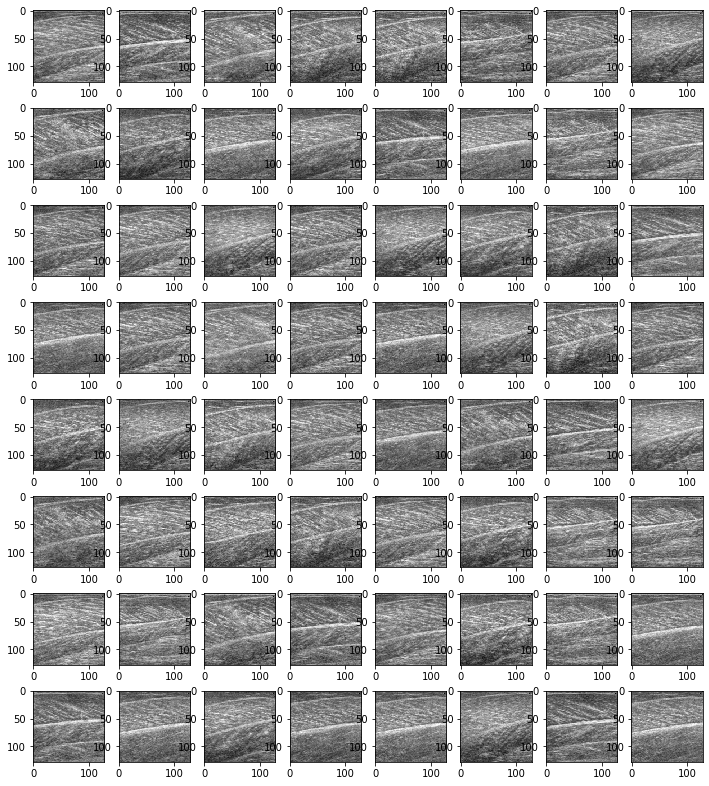

In [9]:
plt.figure(figsize=(12,14))
x= next(train_images);
print(x.shape)
for i in range(x.shape[0]):
    img = x[i]
    img = np.squeeze(img)
    plt.subplot(8,8,i+1)
    plt.imshow(img, cmap='gray')

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 1)

    return model

Use the (as yet untrained) generator to create an image.

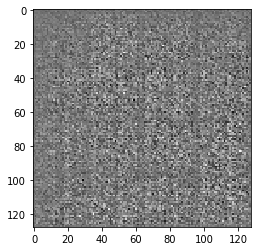

In [11]:
generator = make_generator_model()

noise = tf.random.normal([10, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), padding='same',
                                     input_shape=input_shape[1:]))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)
print(discriminator.summary())

tf.Tensor(
[[0.4999901 ]
 [0.4999984 ]
 [0.49999964]
 [0.49999583]
 [0.4999987 ]
 [0.50000244]
 [0.4999941 ]
 [0.4999978 ]
 [0.49999833]
 [0.50000143]], shape=(10, 1), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
lea

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [17]:
lr = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [19]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(idx, images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return '{}, {}, {}, {}, {}'.format(idx+1, gen_loss, disc_loss, real_output, fake_output)


In [21]:
# select real samples
def generate_real_samples(dataset):
	# choose random instances
# 	ix = randint(0, dataset.samples, n_samples)
	# retrieve selected images
	X_real = next(dataset)
	ix = np.random.randint(0, X_real.shape[0], num_examples_to_generate)
	X_real = X_real[ix]
	X_real = X_real.astype('float32')
	# scale from [0,255] to [-1,1]
	X_real = (X_real - 127.5) / 127.5
	# generate 'real' class labels (1)
	y = ones((X_real.shape[0], 1))
	return X_real, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model):
	# generate points in latent space
	# predict outputs
	X = g_model(seed, training=False)
	# create 'fake' class labels (0)
	y = zeros((num_examples_to_generate, 1))
	return X, y
# create and save a plot of generated images
def save_plot(examples, epoch, filename_start, outputPaths, n=4):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	plt.figure(figsize=(12,14))
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		examples = (lambda img: np.squeeze(img))(examples)
		plt.imshow(examples[i], cmap='gray')
	# save plot to file
	filename = '%s/generated_plot_e%03d.png' % (outputPaths['img'], filename_start+epoch+1)
	plt.savefig(filename)
	plt.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, filename_start=0, outputPaths=time.time()):
	# prepare real samples
# 	X_real, y_real = generate_real_samples(dataset)
# 	# evaluate discriminator on real examples
# 	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
# 	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model)
	# evaluate discriminator on fake examples
# 	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
# 	# summarize discriminator performance
# 	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
# 	log = '>%.0f%%, %.0f%%' % (acc_real*100, acc_fake*100)
# 	write_log(f'{outputPaths["logs"]}/acc.csv', log)
	# save plot
	save_plot(x_fake, epoch, filename_start, outputPaths)
	# save the generator model tile file
	g_filename = '%s/generator_model_%03d.h5' % (outputPaths['gen'], filename_start+epoch+1)
	# save the discriminator model tile file
	d_filename = '%s/discriminator_model_%03d.h5' % (outputPaths['dis'], filename_start+epoch+1)
	g_model.save(g_filename)
	d_model.save(d_filename)

In [22]:
def write_log(path, output):
    with open(path,'a') as f:
        writer = csv.writer(f)
        writer.writerow(output.split(','))

In [23]:
def train(dataset, epochs, outputPaths):
    for epoch in range(epochs):
        start = time.time()

        for j in range(0, dataset.samples, batch_size):
            image_batch = next(dataset)
            image_batch = image_batch.astype('float32')
            # scale from [0,255] to [-1,1]
            image_batch = (image_batch - 127.5) / 127.5
            log = train_step(j, image_batch)
            write_log(f'{outputPaths["logs"]}/log.csv', str(log))

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            summarize_performance(epoch, generator,
                             discriminator, dataset, outputPaths=outputPaths)
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,seed)

**Generate and save images**


In [24]:
def generate_and_save_images(gmodel, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = gmodel(test_input, training=False)
    

    fig = plt.figure(figsize=(12,14))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

#     plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [25]:
def outputDir(rootDir):
    dirNames = ['gen','dis','img','logs']
    paths = dict()
    timer = time.time()
    for name in dirNames:
        path = f'output_g/{timer}_{str(rootDir)}/{name}'
        paths[name] = path
        if not os.path.exists(path):
            os.makedirs(path)
            print("Directory " , path ,  " Created ")
        else:    
            print("Directory " , path ,  " already exists") 
    return paths

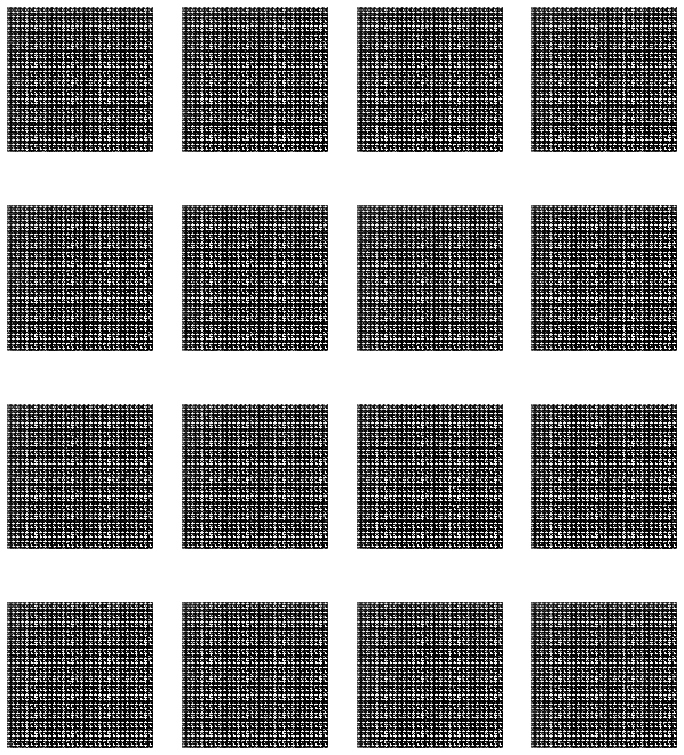

Time for epoch 175 is 3.11464786529541 sec


KeyboardInterrupt: 

In [26]:
train(train_images, EPOCHS, outputPaths = outputDir(lr))

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs we recommend the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
